In [1]:
import pandas as pd
import numpy as np
import random
import easydict
import ast
from tqdm import tqdm_notebook
import os
import matplotlib.pyplot as plt
import sys

from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.models as models
import torch.nn.functional as F

from functions.cus_plot import plot_train_process,plot_different_figs
from functions.helper import *

In [2]:
args=easydict.EasyDict({
    'batch_size':32,
    'epoch':50,
    'data_root_path':'d:/Data/CUB/CUB_200_2011/',
    'csv_path':'save/data/data.csv',
    'lr':0.001,
    'train_log':'save/train_log.txt',
    'train_model':'save/model/base_vgg16.pt',
    'train_img':'save/img/train_process.png',
    'class_nums':200,
    'train_img_size':224,
    'cls_loss':'CE',
    'weight_decay':0.0001,
    'nesterov':False,
    'check_path':'save/train/check.pkl',
    'continue_train':True
})

# Dataloader

In [3]:
class Loader:
    def __init__(self, args, mode='train'):
        self.data_csv = pd.read_csv(args.csv_path)
        self.mode = mode
        self.args = args
        self.img_size = args.train_img_size
        self.class_nums=args.class_nums

        self.train_csv=self.data_csv[self.data_csv['is_train']==1]
        self.val_csv=self.data_csv[self.data_csv['is_train']==0]
        self.train_csv.reset_index(drop=True,inplace=True)
        self.val_csv.reset_index(drop=True,inplace=True)
        
        if self.mode=='train':
            self.cur_csv=self.train_csv
        else:
            self.cur_csv=self.val_csv

    def __getitem__(self, index):
        item = self.cur_csv.loc[index]

        img_id = item['id']
        path = item['path']
        label = item['cls']
        bbox = item['bbox']

        raw_img = Image.open(self.args.data_root_path + path).convert('RGB')
        img = self.image_transform(img_size=self.img_size, mode=self.mode)(raw_img)

        return img_id, img, label, bbox

    def to_train(self):
        self.mode = 'train'
        self.cur_csv = self.train_csv

    def to_val(self):
        self.mode = 'val'
        self.cur_csv = self.val_csv

    def __len__(self):
        return len(self.cur_csv)
    
    @staticmethod
    def image_transform(img_size, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], mode='train'):
        if mode == 'train':
            horizontal_flip = 0.5
            vertical_flip = 0.5

            t = [
                transforms.RandomResizedCrop(size=img_size),
                transforms.RandomHorizontalFlip(horizontal_flip),
                transforms.RandomVerticalFlip(vertical_flip),
                transforms.ColorJitter(saturation=0.4, brightness=0.4, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]

        else:
            t = [
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]

        return transforms.Compose([v for v in t])

# 建模

In [4]:
class Base_vgg16(nn.Module):
    def __init__(self, pre_trained_vgg, args, inference=False, freeze_vgg=False):
        super(Base_vgg16, self).__init__()
        self.inference = inference
        self.freeze_vgg = freeze_vgg
        self.class_nums=args.class_nums

        self.features = pre_trained_vgg.features
        self.cls = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, dilation=1),  # fc6
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, dilation=1),  # fc6
            nn.ReLU(True),
            nn.Conv2d(1024, self.class_nums, kernel_size=1, padding=0)  # fc8
        )

        if self.freeze_vgg:
            for param in self.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        if self.inference:
            x.requires_grad_()
            x.retain_grad()

        base = self.features(x)
        avg_pool = F.avg_pool2d(base, kernel_size=3, stride=1, padding=1)
        cam = self.cls(avg_pool)
        logits = torch.mean(torch.mean(cam, dim=2), dim=2)  # (1,200)

        if self.inference:
            pass

        return logits, cam
    
    def norm_cam_2_binary(self, bi_x_grad):
#         if len(bi_x_grad.size()) == 4:
#             bi_x_grad = bi_x_grad.squeeze(1)

#         grad_shape = bi_x_grad.size()
#         outline = torch.zeros(grad_shape)
#         for batch_idx in range(grad_shape[0]):
#             thd = float(np.percentile(np.sort(bi_x_grad[batch_idx].view(-1).cpu().data.numpy()), 80))
#             batch_outline = torch.zeros(bi_x_grad[batch_idx].size())
#             high_pos = torch.gt(bi_x_grad[batch_idx], thd)
#             batch_outline[high_pos.data] = 1.0
#             outline[batch_idx, :, :] = batch_outline

#         return outline
    
        thd = float(np.percentile(np.sort(bi_x_grad.view(-1).cpu().data.numpy()), 80))
        outline = torch.zeros(bi_x_grad.size())
        high_pos = torch.gt(bi_x_grad, thd)
        outline[high_pos.data] = 1.0
        
        return outline

In [5]:
def get_model(pretrained=True,**kwargs):
    pre_trained_model = models.vgg16(pretrained=pretrained)

    model = Base_vgg16(pre_trained_vgg=pre_trained_model, **kwargs)
    model.cuda()

    return model

# Loss

In [6]:
def get_loss_func(args):
    if args.cls_loss=='CE':
        return torch.nn.CrossEntropyLoss()

# Optimzer

In [7]:
def get_finetune_optimizer(args, model):
    lr = args.lr
    weight_list = []
    bias_list = []
    last_weight_list = []
    last_bias_list = []
    
    for name, value in model.named_parameters():
        if 'cls' in name:
            if 'weight' in name:
                last_weight_list.append(value)
            elif 'bias' in name:
                last_bias_list.append(value)
        else:
            if 'weight' in name:
                weight_list.append(value)
            elif 'bias' in name:
                bias_list.append(value)

    opt = optim.SGD([{'params': weight_list, 'lr': lr / 10},
                     {'params': bias_list, 'lr': lr / 5},
                     {'params': last_weight_list, 'lr': lr},
                     {'params': last_bias_list, 'lr': lr * 2}], momentum=0.9, weight_decay=args.weight_decay, nesterov=args.nesterov)

    return opt

# 训练

In [8]:
#初始化
torch.cuda.empty_cache()
epoch=0
train_acc_arr=[]
val_acc_arr=[]

#加载数据
dataset=Loader(args=args)
dataloader=DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

#加载模型
model=get_model(args=args)

#加载参数
loss_func=get_loss_func(args=args)
    
#训练
if args.continue_train:
    model.load_state_dict(torch.load(args.train_model))
    check_dict=load_check_point(args=args)
    epoch=check_dict['epoch']
    train_acc_arr=check_dict['train_acc_arr']
    val_acc_arr=check_dict['val_acc_arr']
    
while epoch <args.epoch:
    opt = get_finetune_optimizer(args, model)
    
    train_result = []
    train_label = []
    val_result = []
    val_label = []
    
    for step, (img_id, img, label, bbox) in enumerate(dataloader):
        img = img.cuda()
        label = label.cuda()

        logits, cam = model.forward(img)
        loss = loss_func(logits, label)
        acc = cal_acc(logits, label)

        opt.zero_grad()
        loss.backward()
        opt.step()

        print('epoch:{} train loss:{} train acc:{}'.format(epoch, loss, acc))

        train_result.extend(torch.argmax(logits, dim=-1).cpu().data.numpy())
        train_label.extend(label.cpu().data.numpy())
    
    train_acc_arr.append(np.mean(np.array(train_result) == np.array(train_label)))
    
    # validation
    dataset.to_val()
    val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)
    for step, (img_id, img, label, bbox) in enumerate(tqdm_notebook(val_dataloader)):
        img = img.cuda()
        label = label.cuda()

        logits, cam = model.forward(img)
        val_result.extend(torch.argmax(logits, dim=-1).cpu().data.numpy())
        val_label.extend(label.cpu().data.numpy())
        
        if step==0:
            plot_dict={}
            plot_dict['raw_imgs']=get_raw_imgs_by_id(args,img_id[:5],dataset)
            target_cams=torch.zeros(cam.size()[0],cam.size()[2],cam.size()[3])
            for i in range(logits.size()[0]):
                target_cls=torch.argmax(logits[i])
                target_cams[i]=cam[i][target_cls].detach()
                
            plot_dict['cams']=target_cams[:5]
            plot_different_figs(plot_dict)
            

    val_acc_arr.append(np.mean(np.array(val_result) == np.array(val_label)))
    
    if len(val_acc_arr)==1 or val_acc_arr[-1]>=val_acc_arr[-2]:
        torch.save(model.state_dict(), args.train_model)
    
    #plot
    plot_train_process(args,[train_acc_arr,val_acc_arr])
    
    #save check point
    epoch+=1
    save_check_point(args=args,check_dict={
        'epoch':epoch,
        'train_acc_arr':train_acc_arr,
        'val_acc_arr':val_acc_arr
    })
    
    dataset.to_train()

# Result

train acc:0.7585919252585919
val acc:0.6201242664825681


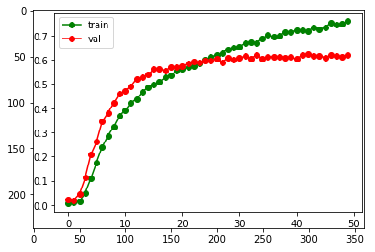

In [9]:
check_dict=load_check_point(args=args)
epoch=check_dict['epoch']
train_acc_arr=check_dict['train_acc_arr']
val_acc_arr=check_dict['val_acc_arr']

print('train acc:{}'.format(train_acc_arr[-1]))
print('val acc:{}'.format(val_acc_arr[-1]))

plt.imshow(read_one_fig(args.train_img))

# 计算validation数据集的iou

In [10]:
#初始化
torch.cuda.empty_cache()

dataset.to_val()
val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

iou_result=[]
cls_result=[]
for step, (img_id, img, label, bbox) in enumerate(tqdm_notebook(val_dataloader)):
    img = img.cuda()
    label = label.cuda()

    logits, cam = model.forward(img)
    cls_predict=torch.argmax(logits,dim=-1)
    raw_imgs=get_raw_imgs_by_id(args,img_id,dataset)
    for i in range(len(img_id)):
        target_cam=cam[i][cls_predict[i]].unsqueeze(0).unsqueeze(0)
        raw_img_size=raw_imgs[i].size
        up_cam=F.upsample(target_cam.detach().cpu().data, size=(raw_img_size[1],raw_img_size[0]), mode='bilinear', align_corners=True)
        binary_cam=model.norm_cam_2_binary(up_cam)
        largest_binary_cam=get_max_binary_area(binary_cam.squeeze().numpy())
        gen_bbox=get_bbox_from_binary_cam(largest_binary_cam)
        iou_result.append(get_iou(gen_bbox,[float(x) for x in bbox[i].split(' ')]))
        
    cls_result.extend(cls_predict.cpu().numpy()==label.cpu().numpy())
    
print('iou result on validation is:{}'.format(np.mean((np.array(iou_result)>0.5)*np.array(cls_result))))
print('iou result on validation detach:{}'.format(np.mean(np.array(iou_result)[np.array(cls_result)]>0.5)))

C:\App\Anaconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
